# 🌀 RealNVP

In this notebook, we'll walk through the steps required to train your own RealNVP network to predict the distribution of a demo dataset

The code has been adapted from the excellent [RealNVP tutorial](https://keras.io/examples/generative/real_nvp) created by Mandolini Giorgio Maria, Sanna Daniele and Zannini Quirini Giorgio available on the Keras website.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KouichiMatsuda/GDL2/blob/main/06_normflow_01_realnvp_realnvp.ipynb)

In [1]:
! mkdir notebooks
%cd notebooks
! wget https://raw.githubusercontent.com/davidADSP/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
%cd ..

/content/notebooks
--2024-06-02 12:10:37--  https://raw.githubusercontent.com/davidADSP/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2024-06-02 12:10:37 (28.0 MB/s) - ‘utils.py’ saved [771/771]

/content


In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    regularizers,
    metrics,
    optimizers,
    callbacks,
)
import tensorflow_probability as tfp

## 0. Parameters <a name="parameters"></a>

In [3]:
COUPLING_DIM = 256
COUPLING_LAYERS = 2
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

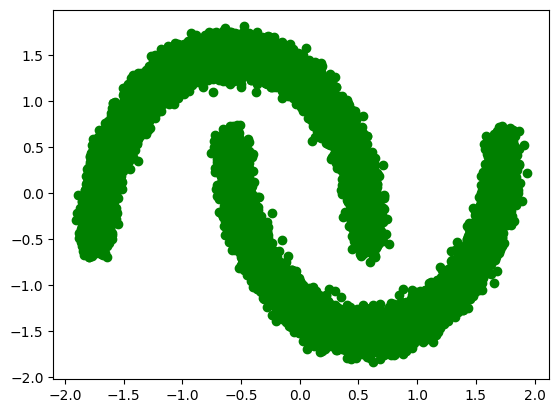

In [4]:
# Load the data
data = datasets.make_moons(30000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)
plt.scatter(
    normalized_data.numpy()[:, 0], normalized_data.numpy()[:, 1], c="green"
)
plt.show()

## 2. Build the RealNVP network <a name="build"></a>

In [5]:
def Coupling(input_dim, coupling_dim, reg):
    input_layer = layers.Input(shape=input_dim)

    s_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    s_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = layers.Dense(
        input_dim, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    t_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    t_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = layers.Dense(
        input_dim, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    return models.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5])

In [6]:
class RealNVP(models.Model):
    def __init__(
        self, input_dim, coupling_layers, coupling_dim, regularization
    ):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = metrics.Mean(name="loss")
        self.layers_list = [
            Coupling(input_dim, coupling_dim, regularization)
            for i in range(coupling_layers)
        ]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, axis=1)
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


model = RealNVP(
    input_dim=INPUT_DIM,
    coupling_layers=COUPLING_LAYERS,
    coupling_dim=COUPLING_DIM,
    regularization=REGULARIZATION,
)

## 3. Train the RealNVP network <a name="train"></a>

In [7]:
# Compile and train the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))

In [8]:
!mkdir logs
!mkdir checkpoints
!mkdir output

In [9]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def generate(self):
        # From data to latent space.
        z, _ = model(normalized_data)

        # From latent space to data.
        samples = model.distribution.sample(self.num_samples)
        x, _ = model.predict(samples, verbose=0)

        return x, z, samples

    def display(self, x, z, samples, save_to=None):
        f, axes = plt.subplots(2, 2)
        f.set_size_inches(8, 5)

        axes[0, 0].scatter(
            normalized_data[:, 0], normalized_data[:, 1], color="r", s=1
        )
        axes[0, 0].set(title="Data space X", xlabel="x_1", ylabel="x_2")
        axes[0, 0].set_xlim([-2, 2])
        axes[0, 0].set_ylim([-2, 2])
        axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s=1)
        axes[0, 1].set(title="f(X)", xlabel="z_1", ylabel="z_2")
        axes[0, 1].set_xlim([-2, 2])
        axes[0, 1].set_ylim([-2, 2])
        axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s=1)
        axes[1, 0].set(title="Latent space Z", xlabel="z_1", ylabel="z_2")
        axes[1, 0].set_xlim([-2, 2])
        axes[1, 0].set_ylim([-2, 2])
        axes[1, 1].scatter(x[:, 0], x[:, 1], color="g", s=1)
        axes[1, 1].set(title="g(Z)", xlabel="x_1", ylabel="x_2")
        axes[1, 1].set_xlim([-2, 2])
        axes[1, 1].set_ylim([-2, 2])

        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        if save_to:
            plt.savefig(save_to)
            print(f"\nSaved to {save_to}")

        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            x, z, samples = self.generate()
            self.display(
                x,
                z,
                samples,
                save_to="./output/generated_img_%03d.png" % (epoch),
            )


img_generator_callback = ImageGenerator(num_samples=3000)

Epoch 1/300
  6/118 [>.............................] - ETA: 1s - loss: 2.8030   

116/118 [============================>.] - ETA: 0s - loss: 2.5577
Saved to ./output/generated_img_000.png


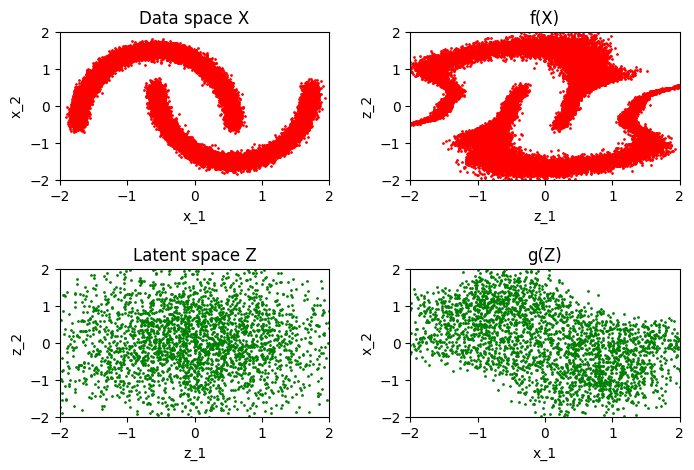

118/118 [==============================] - 10s 25ms/step - loss: 2.5549
Epoch 2/300
118/118 [==============================] - 1s 7ms/step - loss: 2.3252
Epoch 3/300
118/118 [==============================] - 1s 8ms/step - loss: 2.1646
Epoch 4/300
118/118 [==============================] - 1s 7ms/step - loss: 2.0685
Epoch 5/300
118/118 [==============================] - 1s 7ms/step - loss: 2.0147
Epoch 6/300
118/118 [==============================] - 1s 7ms/step - loss: 1.9611
Epoch 7/300
118/118 [==============================] - 1s 7ms/step - loss: 1.8202
Epoch 8/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7704
Epoch 9/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7651
Epoch 10/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7534
Epoch 11/300
112/118 [===========================>..] - ETA: 0s - loss: 1.7499
Saved to ./output/generated_img_010.png


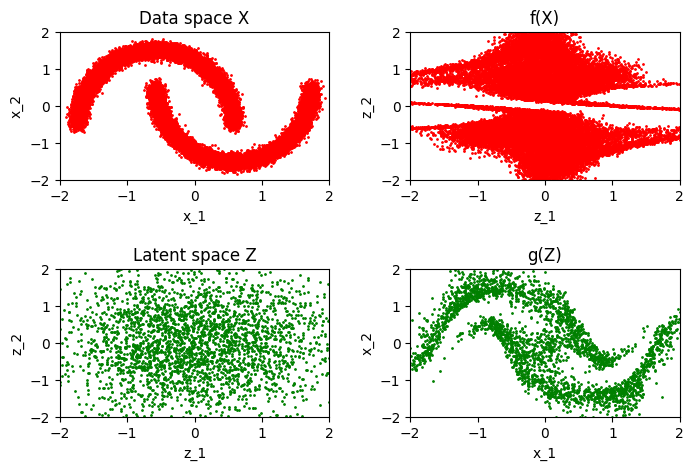

118/118 [==============================] - 2s 17ms/step - loss: 1.7501
Epoch 12/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7463
Epoch 13/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7434
Epoch 14/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7343
Epoch 15/300
118/118 [==============================] - 1s 8ms/step - loss: 1.7406
Epoch 16/300
118/118 [==============================] - 1s 8ms/step - loss: 1.7327
Epoch 17/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7340
Epoch 18/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7268
Epoch 19/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7368
Epoch 20/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7322
Epoch 21/300
116/118 [============================>.] - ETA: 0s - loss: 1.7223
Saved to ./output/generated_img_020.png


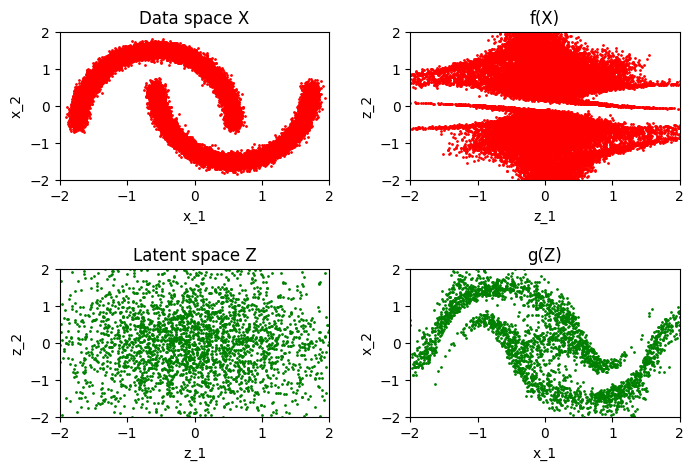

118/118 [==============================] - 2s 18ms/step - loss: 1.7230
Epoch 22/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7237
Epoch 23/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7214
Epoch 24/300
118/118 [==============================] - 1s 8ms/step - loss: 1.7259
Epoch 25/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7315
Epoch 26/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7298
Epoch 27/300
118/118 [==============================] - 1s 8ms/step - loss: 1.7234
Epoch 28/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7227
Epoch 29/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7241
Epoch 30/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7258
Epoch 31/300
112/118 [===========================>..] - ETA: 0s - loss: 1.7197
Saved to ./output/generated_img_030.png


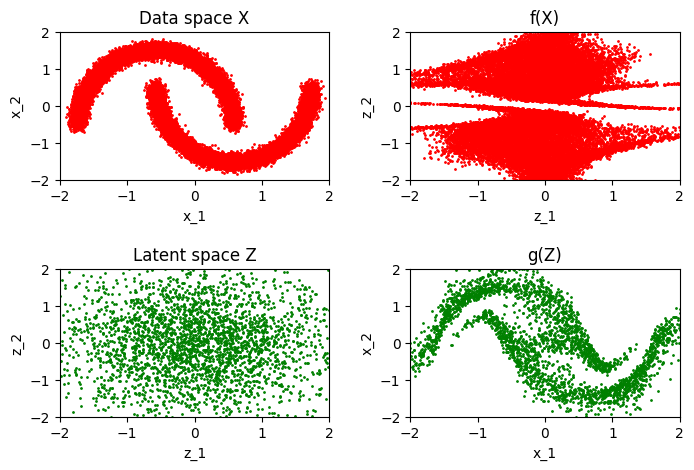

118/118 [==============================] - 2s 18ms/step - loss: 1.7183
Epoch 32/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7203
Epoch 33/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7170
Epoch 34/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7134
Epoch 35/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7162
Epoch 36/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7165
Epoch 37/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7166
Epoch 38/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7209
Epoch 39/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7210
Epoch 40/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7181
Epoch 41/300
112/118 [===========================>..] - ETA: 0s - loss: 1.7142
Saved to ./output/generated_img_040.png


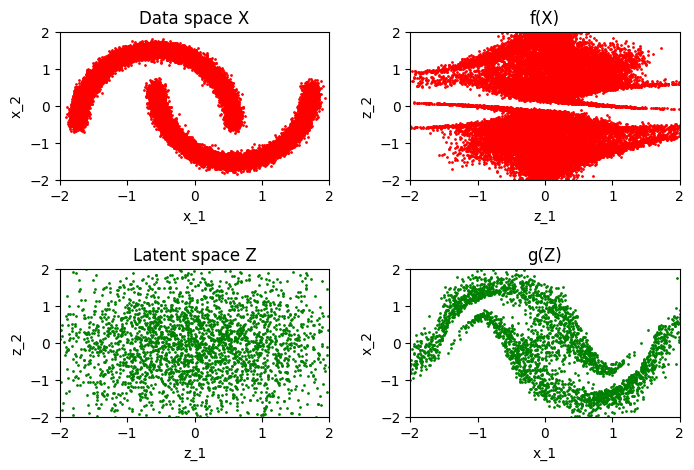

118/118 [==============================] - 2s 18ms/step - loss: 1.7143
Epoch 42/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7084
Epoch 43/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7115
Epoch 44/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7244
Epoch 45/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7216
Epoch 46/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7127
Epoch 47/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7160
Epoch 48/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7114
Epoch 49/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7150
Epoch 50/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7145
Epoch 51/300
116/118 [============================>.] - ETA: 0s - loss: 1.7219
Saved to ./output/generated_img_050.png


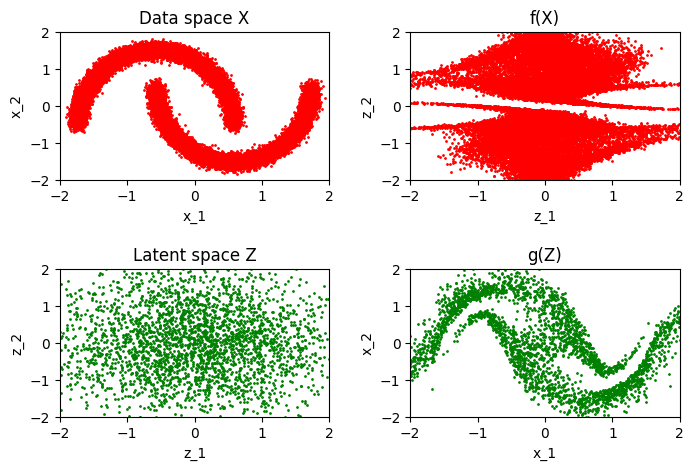

118/118 [==============================] - 2s 18ms/step - loss: 1.7227
Epoch 52/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7131
Epoch 53/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7071
Epoch 54/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7144
Epoch 55/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7184
Epoch 56/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7072
Epoch 57/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7153
Epoch 58/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7139
Epoch 59/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7136
Epoch 60/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7083
Epoch 61/300
115/118 [============================>.] - ETA: 0s - loss: 1.7064
Saved to ./output/generated_img_060.png


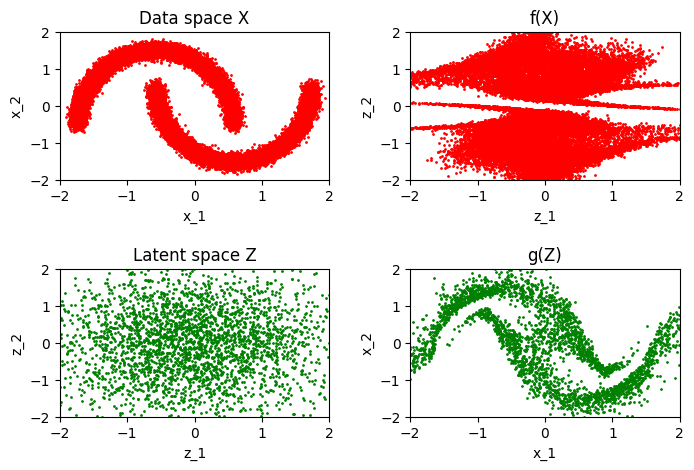

118/118 [==============================] - 2s 18ms/step - loss: 1.7055
Epoch 62/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7108
Epoch 63/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7102
Epoch 64/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7168
Epoch 65/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7193
Epoch 66/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7149
Epoch 67/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7101
Epoch 68/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7061
Epoch 69/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7098
Epoch 70/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7103
Epoch 71/300
112/118 [===========================>..] - ETA: 0s - loss: 1.7140
Saved to ./output/generated_img_070.png


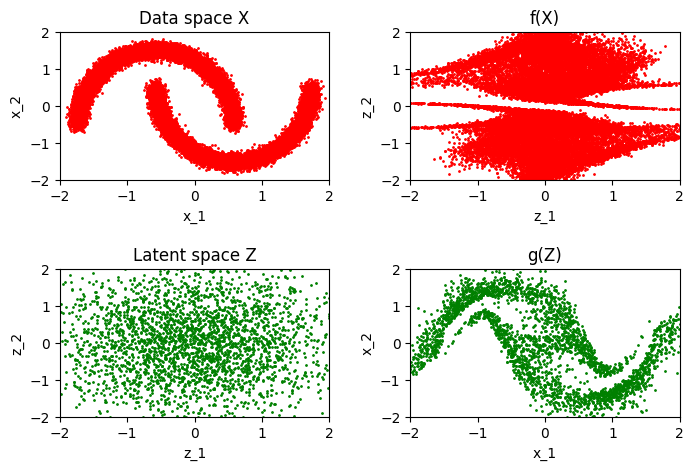

118/118 [==============================] - 2s 17ms/step - loss: 1.7141
Epoch 72/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7083
Epoch 73/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7096
Epoch 74/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7217
Epoch 75/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7089
Epoch 76/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7062
Epoch 77/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7080
Epoch 78/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7064
Epoch 79/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7115
Epoch 80/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7042
Epoch 81/300
111/118 [===========================>..] - ETA: 0s - loss: 1.7049
Saved to ./output/generated_img_080.png


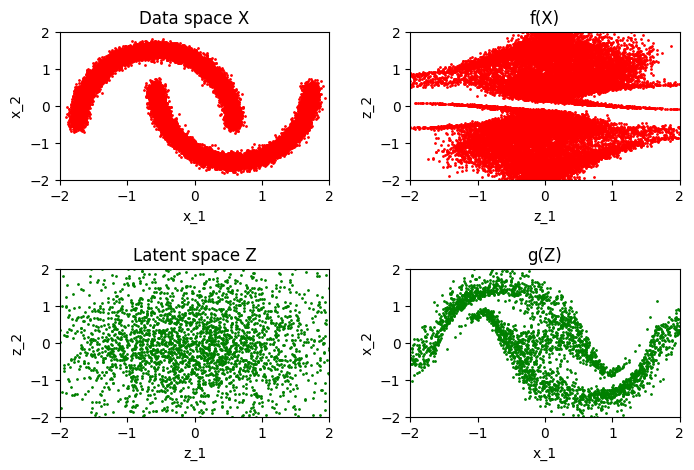

118/118 [==============================] - 2s 17ms/step - loss: 1.7043
Epoch 82/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7056
Epoch 83/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7020
Epoch 84/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7092
Epoch 85/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7054
Epoch 86/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7028
Epoch 87/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7057
Epoch 88/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7136
Epoch 89/300
118/118 [==============================] - 1s 8ms/step - loss: 1.7053
Epoch 90/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7115
Epoch 91/300
112/118 [===========================>..] - ETA: 0s - loss: 1.7145
Saved to ./output/generated_img_090.png


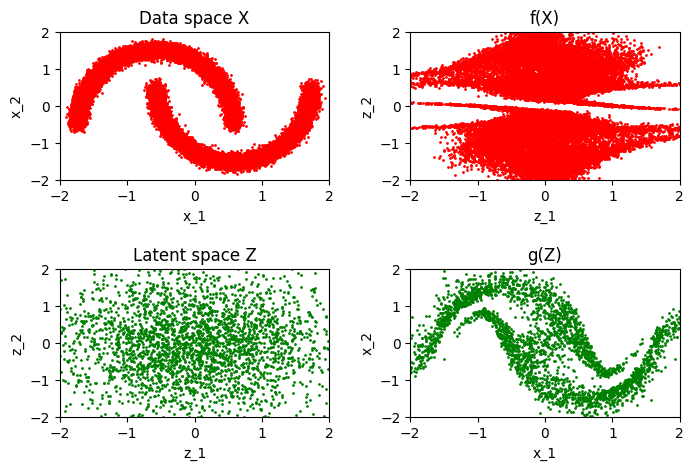

118/118 [==============================] - 2s 18ms/step - loss: 1.7120
Epoch 92/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7056
Epoch 93/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7140
Epoch 94/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7021
Epoch 95/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7116
Epoch 96/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7123
Epoch 97/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7095
Epoch 98/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7184
Epoch 99/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7050
Epoch 100/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7022
Epoch 101/300
116/118 [============================>.] - ETA: 0s - loss: 1.7069
Saved to ./output/generated_img_100.png


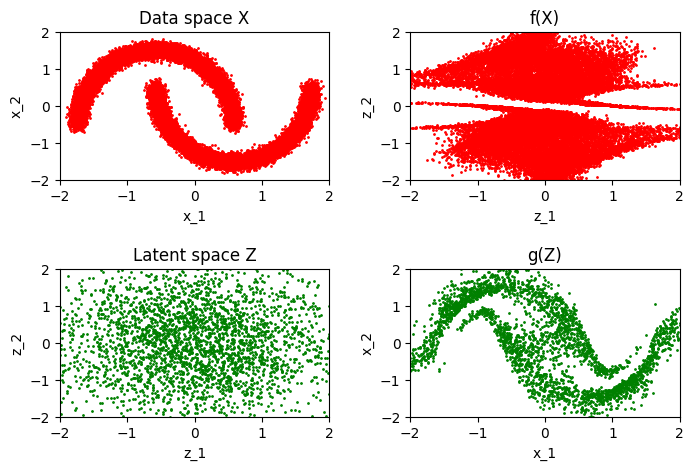

118/118 [==============================] - 2s 18ms/step - loss: 1.7056
Epoch 102/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7053
Epoch 103/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7016
Epoch 104/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7031
Epoch 105/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7094
Epoch 106/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7054
Epoch 107/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7045
Epoch 108/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7069
Epoch 109/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7117
Epoch 110/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7030
Epoch 111/300
113/118 [===========================>..] - ETA: 0s - loss: 1.7072
Saved to ./output/generated_img_110.png


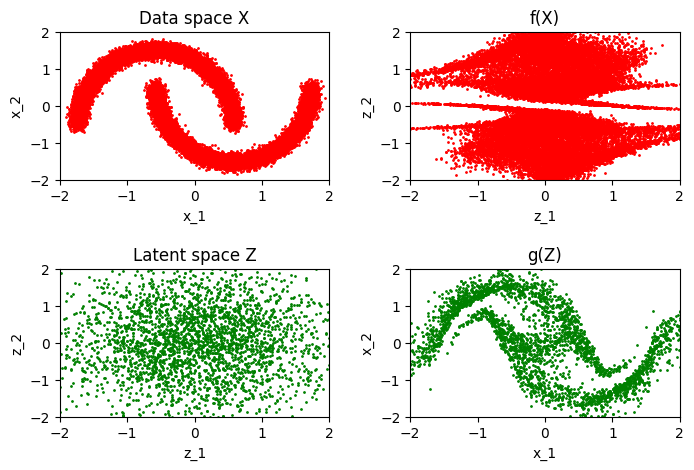

118/118 [==============================] - 2s 17ms/step - loss: 1.7068
Epoch 112/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7069
Epoch 113/300
118/118 [==============================] - 1s 8ms/step - loss: 1.7083
Epoch 114/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7110
Epoch 115/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7067
Epoch 116/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7099
Epoch 117/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7060
Epoch 118/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7040
Epoch 119/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7023
Epoch 120/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7055
Epoch 121/300
112/118 [===========================>..] - ETA: 0s - loss: 1.7075
Saved to ./output/generated_img_120.png


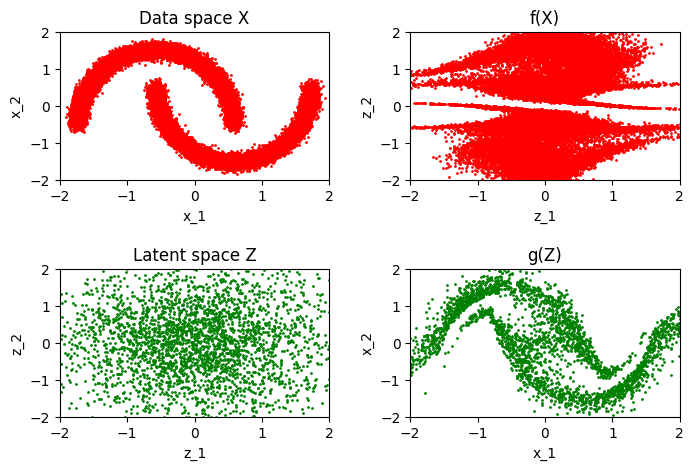

118/118 [==============================] - 2s 17ms/step - loss: 1.7070
Epoch 122/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7025
Epoch 123/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7059
Epoch 124/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7092
Epoch 125/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7030
Epoch 126/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7046
Epoch 127/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7132
Epoch 128/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7050
Epoch 129/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7023
Epoch 130/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7082
Epoch 131/300
111/118 [===========================>..] - ETA: 0s - loss: 1.7065
Saved to ./output/generated_img_130.png


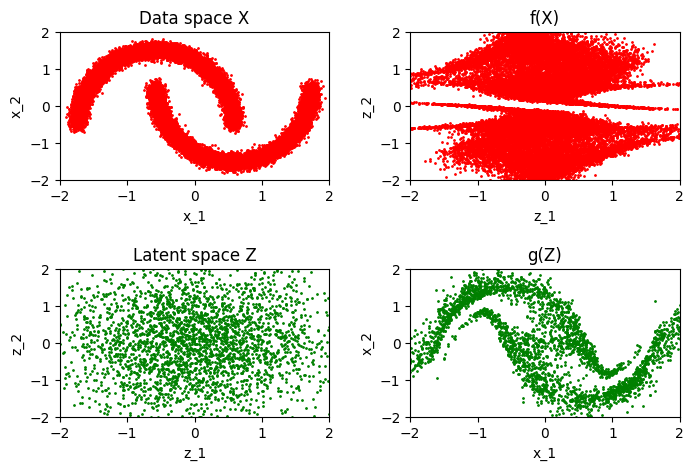

118/118 [==============================] - 2s 17ms/step - loss: 1.7055
Epoch 132/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7067
Epoch 133/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7086
Epoch 134/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7099
Epoch 135/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7014
Epoch 136/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7098
Epoch 137/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7052
Epoch 138/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7048
Epoch 139/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7011
Epoch 140/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7039
Epoch 141/300
112/118 [===========================>..] - ETA: 0s - loss: 1.7054
Saved to ./output/generated_img_140.png


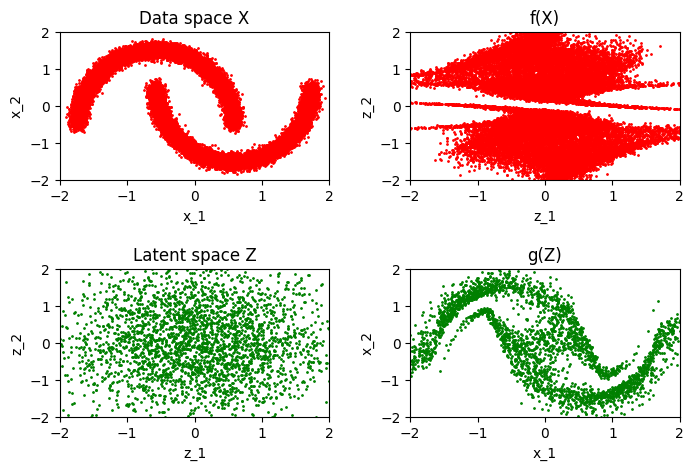

118/118 [==============================] - 2s 17ms/step - loss: 1.7035
Epoch 142/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7033
Epoch 143/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7087
Epoch 144/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7029
Epoch 145/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7023
Epoch 146/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7014
Epoch 147/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7029
Epoch 148/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7071
Epoch 149/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7108
Epoch 150/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7034
Epoch 151/300
112/118 [===========================>..] - ETA: 0s - loss: 1.7033
Saved to ./output/generated_img_150.png


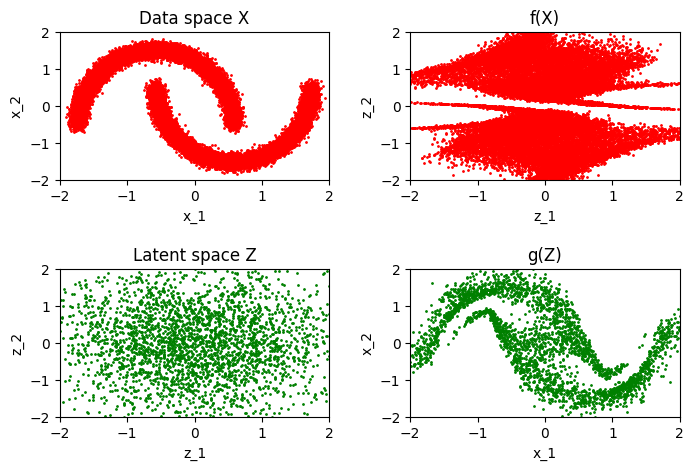

118/118 [==============================] - 2s 18ms/step - loss: 1.7001
Epoch 152/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6994
Epoch 153/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7029
Epoch 154/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7056
Epoch 155/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7070
Epoch 156/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7094
Epoch 157/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7015
Epoch 158/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7026
Epoch 159/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7116
Epoch 160/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7025
Epoch 161/300
112/118 [===========================>..] - ETA: 0s - loss: 1.6992
Saved to ./output/generated_img_160.png


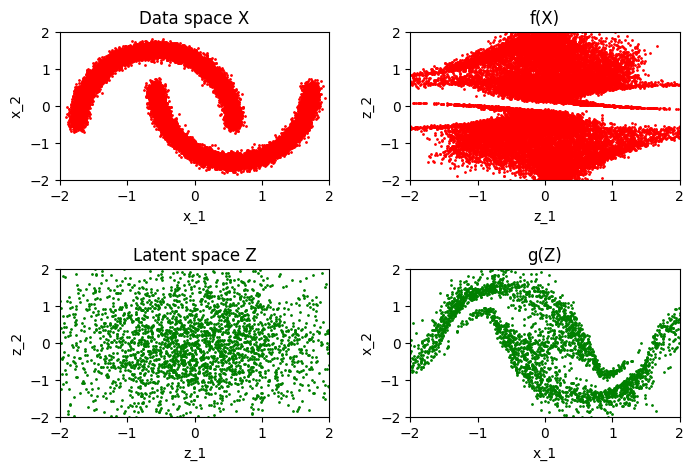

118/118 [==============================] - 2s 18ms/step - loss: 1.6985
Epoch 162/300
118/118 [==============================] - 1s 8ms/step - loss: 1.6998
Epoch 163/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7016
Epoch 164/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7006
Epoch 165/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7009
Epoch 166/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7022
Epoch 167/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7071
Epoch 168/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7140
Epoch 169/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7045
Epoch 170/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7032
Epoch 171/300
118/118 [==============================] - ETA: 0s - loss: 1.7029
Saved to ./output/generated_img_170.png


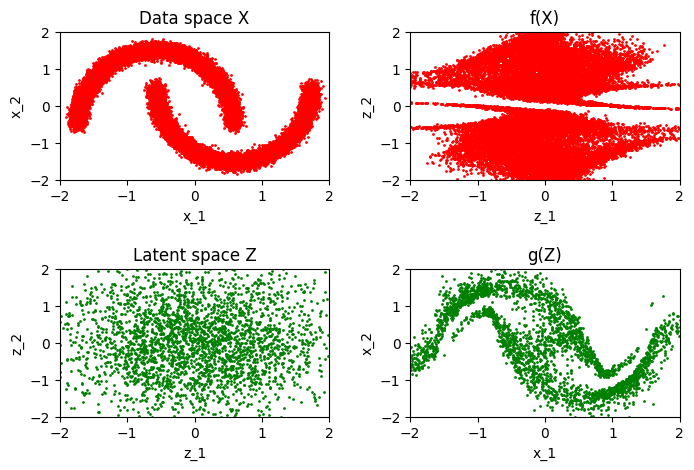

118/118 [==============================] - 2s 17ms/step - loss: 1.7029
Epoch 172/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7018
Epoch 173/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7014
Epoch 174/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6987
Epoch 175/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7067
Epoch 176/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7101
Epoch 177/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7011
Epoch 178/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6991
Epoch 179/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7076
Epoch 180/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6981
Epoch 181/300
116/118 [============================>.] - ETA: 0s - loss: 1.6968
Saved to ./output/generated_img_180.png


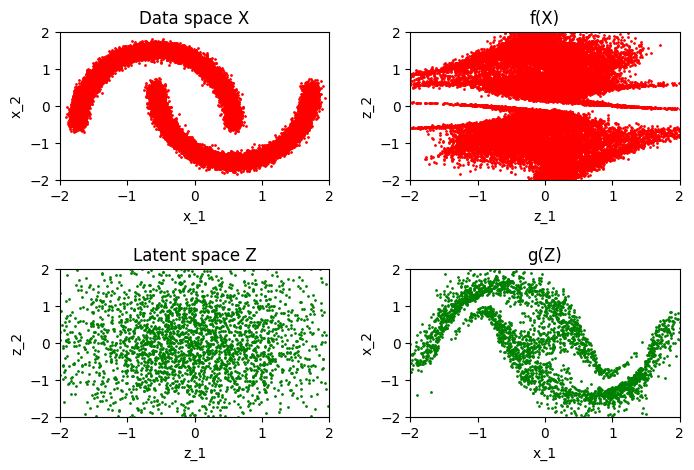

118/118 [==============================] - 2s 18ms/step - loss: 1.6974
Epoch 182/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7091
Epoch 183/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7032
Epoch 184/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7016
Epoch 185/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7037
Epoch 186/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6996
Epoch 187/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6996
Epoch 188/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7014
Epoch 189/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7062
Epoch 190/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7019
Epoch 191/300
116/118 [============================>.] - ETA: 0s - loss: 1.7074
Saved to ./output/generated_img_190.png


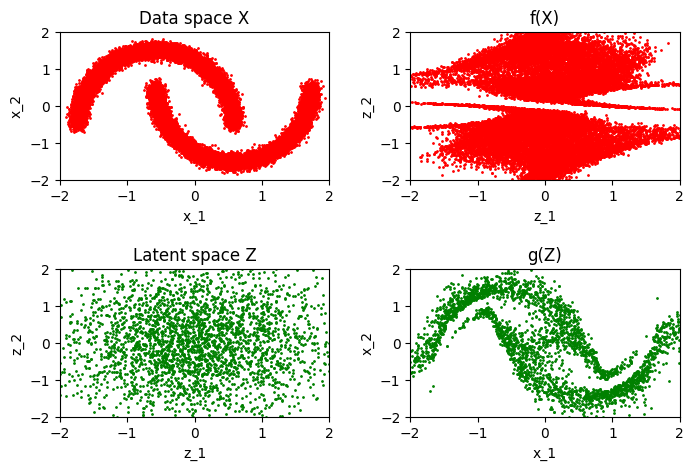

118/118 [==============================] - 2s 17ms/step - loss: 1.7076
Epoch 192/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7001
Epoch 193/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7007
Epoch 194/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7021
Epoch 195/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7009
Epoch 196/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7003
Epoch 197/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7049
Epoch 198/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7022
Epoch 199/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6958
Epoch 200/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7006
Epoch 201/300
112/118 [===========================>..] - ETA: 0s - loss: 1.7068
Saved to ./output/generated_img_200.png


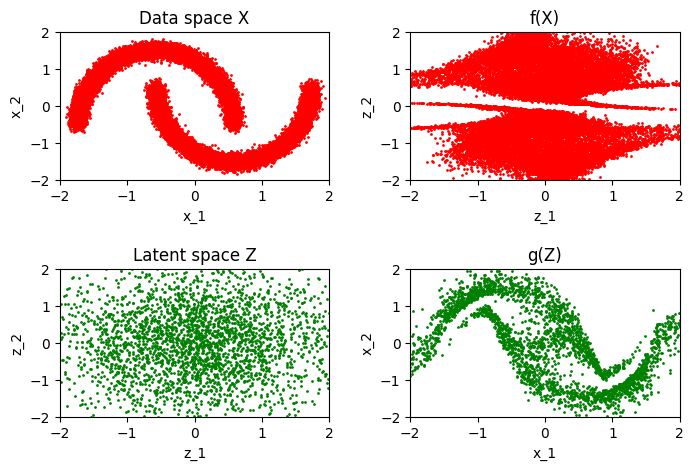

118/118 [==============================] - 2s 17ms/step - loss: 1.7041
Epoch 202/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7002
Epoch 203/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6969
Epoch 204/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7007
Epoch 205/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6997
Epoch 206/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6995
Epoch 207/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7078
Epoch 208/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6967
Epoch 209/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6995
Epoch 210/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6967
Epoch 211/300
116/118 [============================>.] - ETA: 0s - loss: 1.7001
Saved to ./output/generated_img_210.png


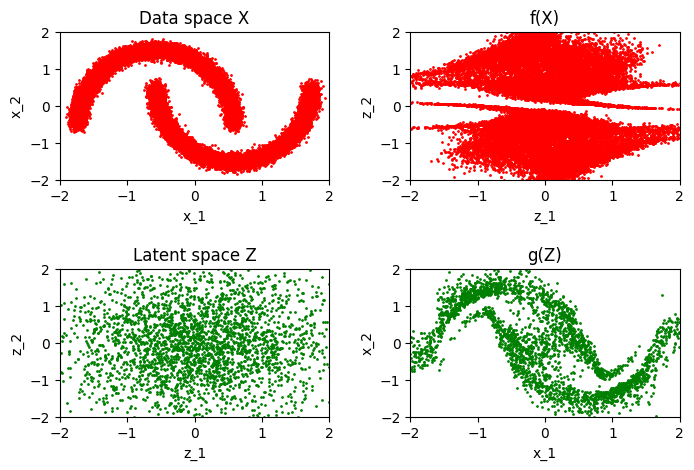

118/118 [==============================] - 2s 18ms/step - loss: 1.7001
Epoch 212/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6981
Epoch 213/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6962
Epoch 214/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7079
Epoch 215/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7040
Epoch 216/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7061
Epoch 217/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7032
Epoch 218/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7030
Epoch 219/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6990
Epoch 220/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6971
Epoch 221/300
115/118 [============================>.] - ETA: 0s - loss: 1.7009
Saved to ./output/generated_img_220.png


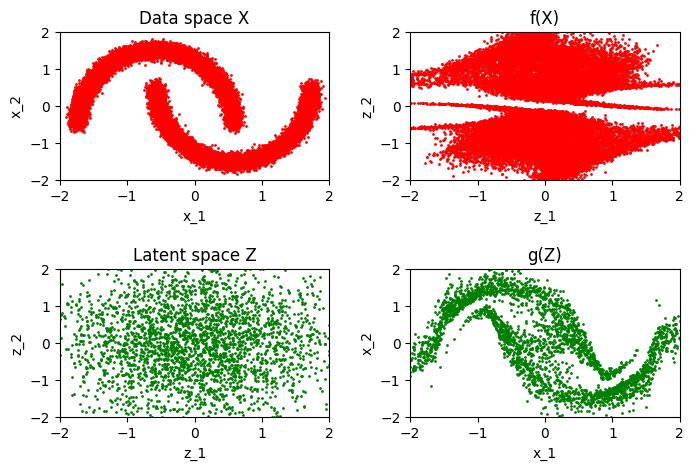

118/118 [==============================] - 2s 18ms/step - loss: 1.6998
Epoch 222/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7020
Epoch 223/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6987
Epoch 224/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6999
Epoch 225/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6992
Epoch 226/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6974
Epoch 227/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6968
Epoch 228/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6971
Epoch 229/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6996
Epoch 230/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6954
Epoch 231/300
112/118 [===========================>..] - ETA: 0s - loss: 1.6981
Saved to ./output/generated_img_230.png


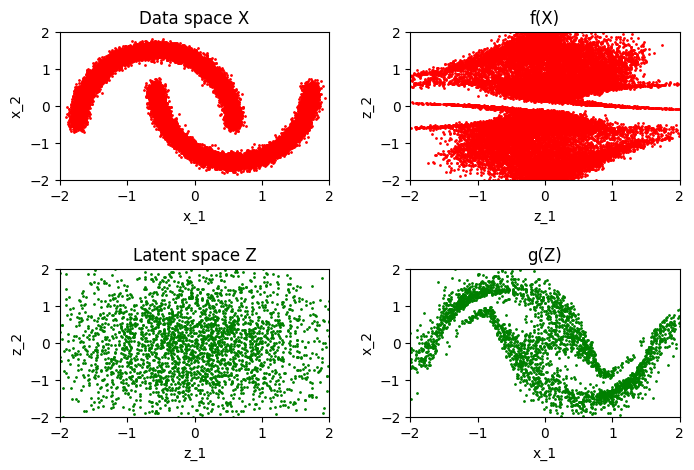

118/118 [==============================] - 2s 17ms/step - loss: 1.6975
Epoch 232/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6956
Epoch 233/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7014
Epoch 234/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6995
Epoch 235/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6965
Epoch 236/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6968
Epoch 237/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7036
Epoch 238/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6999
Epoch 239/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6988
Epoch 240/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7001
Epoch 241/300
113/118 [===========================>..] - ETA: 0s - loss: 1.6949
Saved to ./output/generated_img_240.png


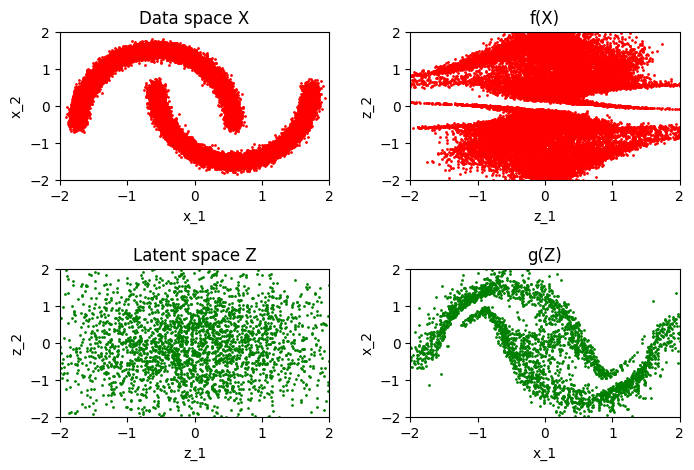

118/118 [==============================] - 2s 17ms/step - loss: 1.6958
Epoch 242/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6998
Epoch 243/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7000
Epoch 244/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7014
Epoch 245/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7003
Epoch 246/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6972
Epoch 247/300
118/118 [==============================] - 1s 8ms/step - loss: 1.7014
Epoch 248/300
118/118 [==============================] - 1s 8ms/step - loss: 1.6997
Epoch 249/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6991
Epoch 250/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7017
Epoch 251/300
116/118 [============================>.] - ETA: 0s - loss: 1.6989
Saved to ./output/generated_img_250.png


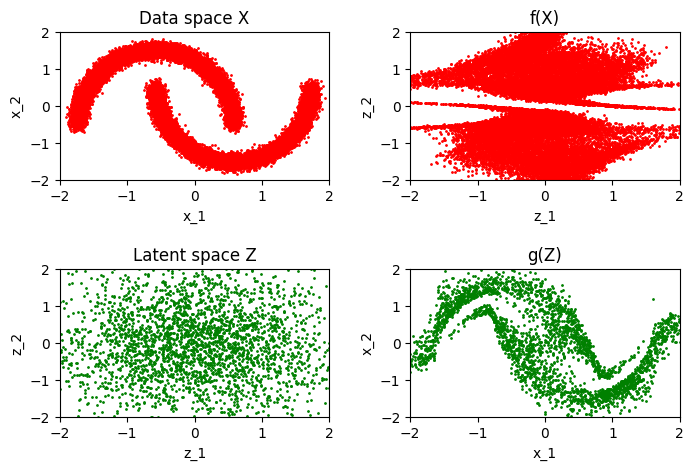

118/118 [==============================] - 2s 18ms/step - loss: 1.6978
Epoch 252/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6987
Epoch 253/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6998
Epoch 254/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6968
Epoch 255/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7028
Epoch 256/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6995
Epoch 257/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7030
Epoch 258/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6958
Epoch 259/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7000
Epoch 260/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6963
Epoch 261/300
115/118 [============================>.] - ETA: 0s - loss: 1.6995
Saved to ./output/generated_img_260.png


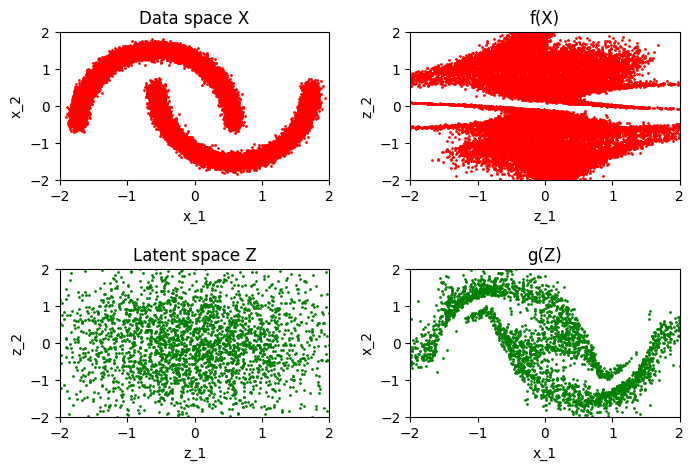

118/118 [==============================] - 2s 17ms/step - loss: 1.6979
Epoch 262/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6995
Epoch 263/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6985
Epoch 264/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6962
Epoch 265/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6973
Epoch 266/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7006
Epoch 267/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7001
Epoch 268/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6978
Epoch 269/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7013
Epoch 270/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6962
Epoch 271/300
114/118 [===========================>..] - ETA: 0s - loss: 1.7030
Saved to ./output/generated_img_270.png


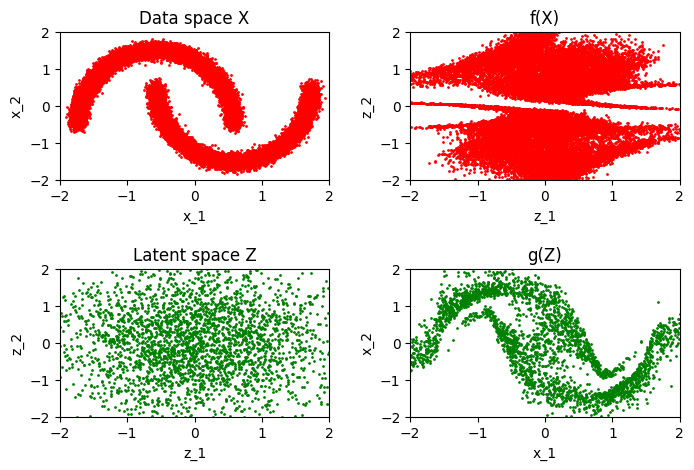

118/118 [==============================] - 2s 18ms/step - loss: 1.7022
Epoch 272/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6967
Epoch 273/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7024
Epoch 274/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6948
Epoch 275/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7026
Epoch 276/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7009
Epoch 277/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7033
Epoch 278/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7013
Epoch 279/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6962
Epoch 280/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6973
Epoch 281/300
113/118 [===========================>..] - ETA: 0s - loss: 1.7009
Saved to ./output/generated_img_280.png


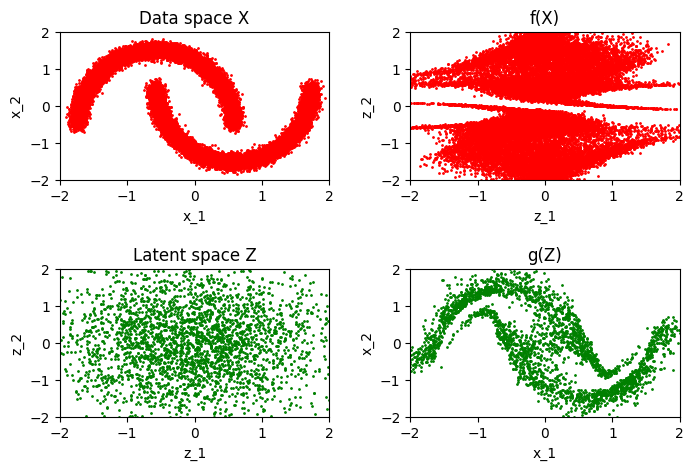

118/118 [==============================] - 2s 18ms/step - loss: 1.7010
Epoch 282/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6995
Epoch 283/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6994
Epoch 284/300
118/118 [==============================] - 1s 8ms/step - loss: 1.7002
Epoch 285/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6992
Epoch 286/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6968
Epoch 287/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6968
Epoch 288/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6956
Epoch 289/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6949
Epoch 290/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7030
Epoch 291/300
112/118 [===========================>..] - ETA: 0s - loss: 1.7014
Saved to ./output/generated_img_290.png


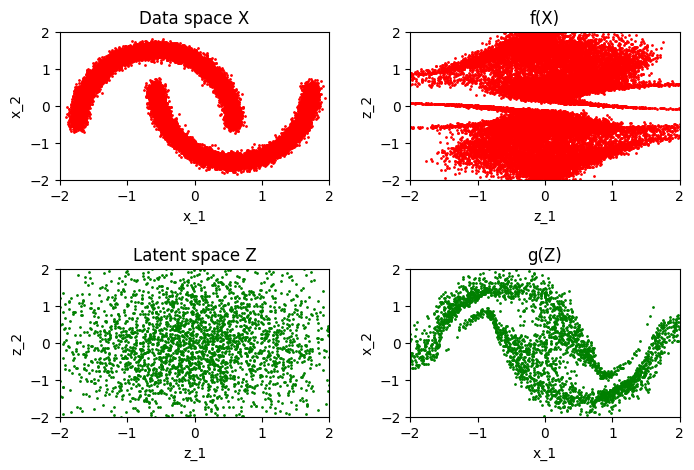

118/118 [==============================] - 2s 20ms/step - loss: 1.7014
Epoch 292/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6974
Epoch 293/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6948
Epoch 294/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7004
Epoch 295/300
118/118 [==============================] - 1s 8ms/step - loss: 1.6967
Epoch 296/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6998
Epoch 297/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6983
Epoch 298/300
118/118 [==============================] - 1s 7ms/step - loss: 1.6969
Epoch 299/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7003
Epoch 300/300
118/118 [==============================] - 1s 7ms/step - loss: 1.7035


In [10]:
model.fit(
    normalized_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

## 4. Generate images <a name="generate"></a>

In [11]:
x, z, samples = img_generator_callback.generate()

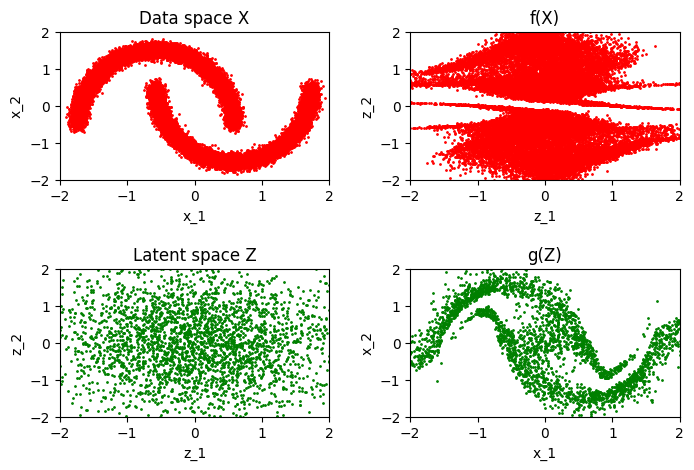

In [12]:
img_generator_callback.display(x, z, samples)